In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings
import glob
warnings.filterwarnings('ignore')
from PIL import Image
import tensorflow as tf
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers as ly
tf.get_logger().setLevel('WARNING')
from google.colab import drive
drive.mount('/content/drive')
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir animals/

In [ ]:
batch_size = 64
image_dimensions = (224, 224)

In [ ]:
org_dir = "/content/drive/MyDrive/animals151/dataset/dataset"

In [ ]:
class_labels = os.listdir(org_dir)
for class_label in class_labels:
    directory_path = f"animals/{class_label}/"
    if not os.path.exists(directory_path):
        os.mkdir(directory_path)

In [ ]:
image_files = glob.glob(f"{org_dir}/*/*.jpg")

In [ ]:
for file_path in tqdm(image_files, desc="Processing Images"):
    path_parts = file_path.split("/")
    label = path_parts[-2]
    filename = path_parts[-1]

    image = Image.open(file_path).convert('RGB')
    save_path = f"animals/{label}/{filename}"
    image.save(save_path)

Processing Images:  51%|█████     | 3191/6270 [17:19<14:19,  3.58it/s]

In [ ]:
copied_dir = "animals/"

In [ ]:
random_seed = 42

train_dataset = keras.utils.image_dataset_from_directory(
    copied_dir,
    validation_split=0.2,
    subset='training',
    batch_size=batch_size,
    image_size=image_dimensions,
    shuffle=True,
    seed=random_seed
)

validation_dataset = keras.utils.image_dataset_from_directory(
    copied_dir,
    validation_split=0.2,
    subset='validation',
    batch_size=batch_size,
    image_size=image_dimensions,
    shuffle=True,
    seed=random_seed
)

Found 6270 files belonging to 151 classes.
Using 5016 files for training.
Found 6270 files belonging to 151 classes.
Using 1254 files for validation.


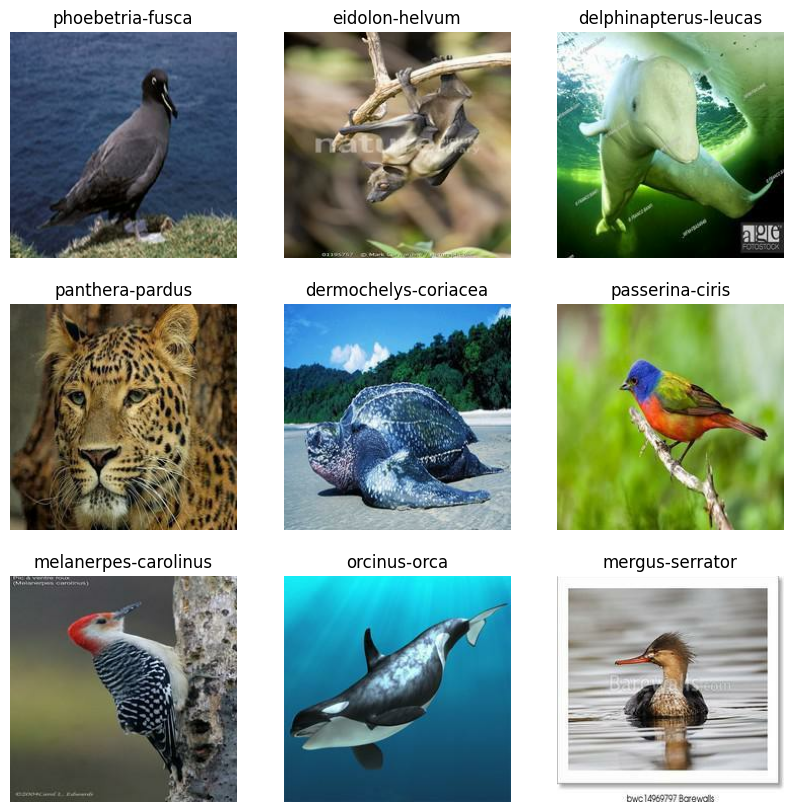

In [ ]:
class_names = train_dataset.class_names

num_rows, num_cols = 3, 3

plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):

    for row in range(num_rows):

        for col in range(num_cols):

            index = row * num_cols + col

            current_image = images[index].numpy().astype("uint8")
            current_label = class_names[labels[index]]

            ax = plt.subplot(num_rows, num_cols, index + 1)

            plt.imshow(current_image)
            plt.title(current_label)
            plt.axis("off")


In [ ]:
validation_batches = tf.data.experimental.cardinality(validation_dataset)

test_dataset = validation_dataset.take(validation_batches // 4)

validation_dataset = validation_dataset.skip(validation_batches // 4)

In [ ]:
train_batches = tf.data.experimental.cardinality(train_dataset)
validation_batches = tf.data.experimental.cardinality(validation_dataset)
test_batches = tf.data.experimental.cardinality(test_dataset)

print(f'Number of train batches: {train_batches}')
print(f'Number of validation batches: {validation_batches}')
print(f'Number of test batches: {test_batches}')

Number of train batches: 79
Number of validation batches: 15
Number of test batches: 5


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
image_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(),
    # tf.keras.layers.RandomRotation(0.2),
    # tf.keras.layers.RandomZoom(0.2)
])

In [ ]:
image_shape = image_dimensions + (3,)
base_model = tf.keras.applications.EfficientNetB0(input_shape=image_shape, include_top=False, weights='imagenet')

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
global_avg_pooling = tf.keras.layers.GlobalAveragePooling2D()
prediction = tf.keras.layers.Dense(len(class_names))

In [ ]:
inputs = tf.keras.Input(shape=image_shape)

x = image_augmentation(inputs)
x = base_model(x, training=False)

x = global_avg_pooling(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset
)

Epoch 1/5
79/79 [==============================] - 629s 8s/step - loss: 3.4137 - accuracy: 0.4151 - val_loss: 1.8503 - val_accuracy: 0.7719
Epoch 2/5
79/79 [==============================] - 531s 7s/step - loss: 1.3100 - accuracy: 0.8166 - val_loss: 0.9779 - val_accuracy: 0.8533
Epoch 3/5
79/79 [==============================] - 520s 7s/step - loss: 0.7371 - accuracy: 0.8894 - val_loss: 0.6877 - val_accuracy: 0.8758
Epoch 4/5
79/79 [==============================] - 531s 7s/step - loss: 0.5189 - accuracy: 0.9226 - val_loss: 0.5771 - val_accuracy: 0.8919
Epoch 5/5
79/79 [==============================] - 529s 7s/step - loss: 0.3909 - accuracy: 0.9468 - val_loss: 0.5073 - val_accuracy: 0.8929


In [ ]:
evaluation_result = model.evaluate(test_dataset)
print("Accuracy: {:.3f}%".format(evaluation_result[1] * 100))

5/5 [==============================] - 32s 6s/step - loss: 0.4995 - accuracy: 0.8906
Accuracy: 89.062%


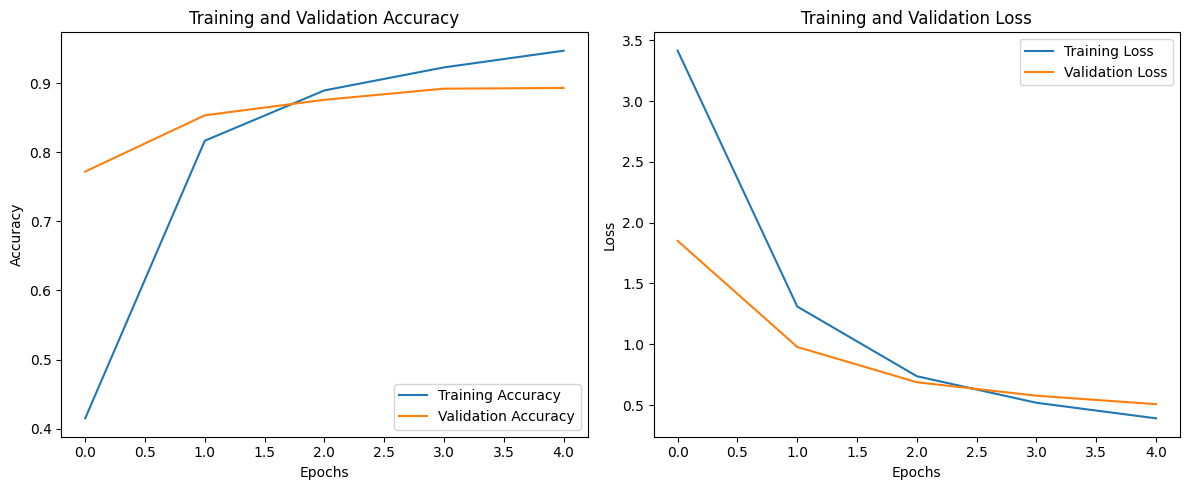

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [36]:
class_labels = os.listdir(org_dir)
print("Class Names:", class_labels)

Class Names: ['ursus-maritimus', 'trilobita', 'vulpes-vulpes', 'tyrannus-tyrannus', 'tyrannosaurus-rex', 'tursiops-truncatus', 'varanus-komodoensis', 'turdus-migratorius', 'ursus-arctos-horribilis', 'vultur-gryphus', 'sphyrna-mokarran', 'thryothorus-ludovicianus', 'tapirus', 'spinosaurus-aegyptiacus', 'telmatobufo-bullocki', 'struthio-camelus', 'taurotragus-oryx', 'triceratops-horridus', 'stegosaurus-stenops', 'tarsius-pumilus', 'pterois-mombasae', 'spheniscus-demersus', 'sciurus-carolinensis', 'rusa-unicolor', 'rattus-rattus', 'pterois-volitans', 'pteranodon-longiceps', 'smilodon-populator', 'salmo-salar', 'puma-concolor', 'phoenicopterus-ruber', 'physeter-macrocephalus', 'physalia-physalis', 'periplaneta-americana', 'phascolarctos-cinereus', 'poecile-atricapillus', 'phoebetria-fusca', 'procyon-lotor', 'phyllobates-terribilis', 'pongo-abelii', 'passerina-ciris', 'papilio-glaucus', 'pantherophis-guttatus', 'ovis-canadensis', 'panthera-leo', 'panthera-onca', 'pavo-cristatus', 'panthera-

2/2 [==============================] - 3s 2s/step


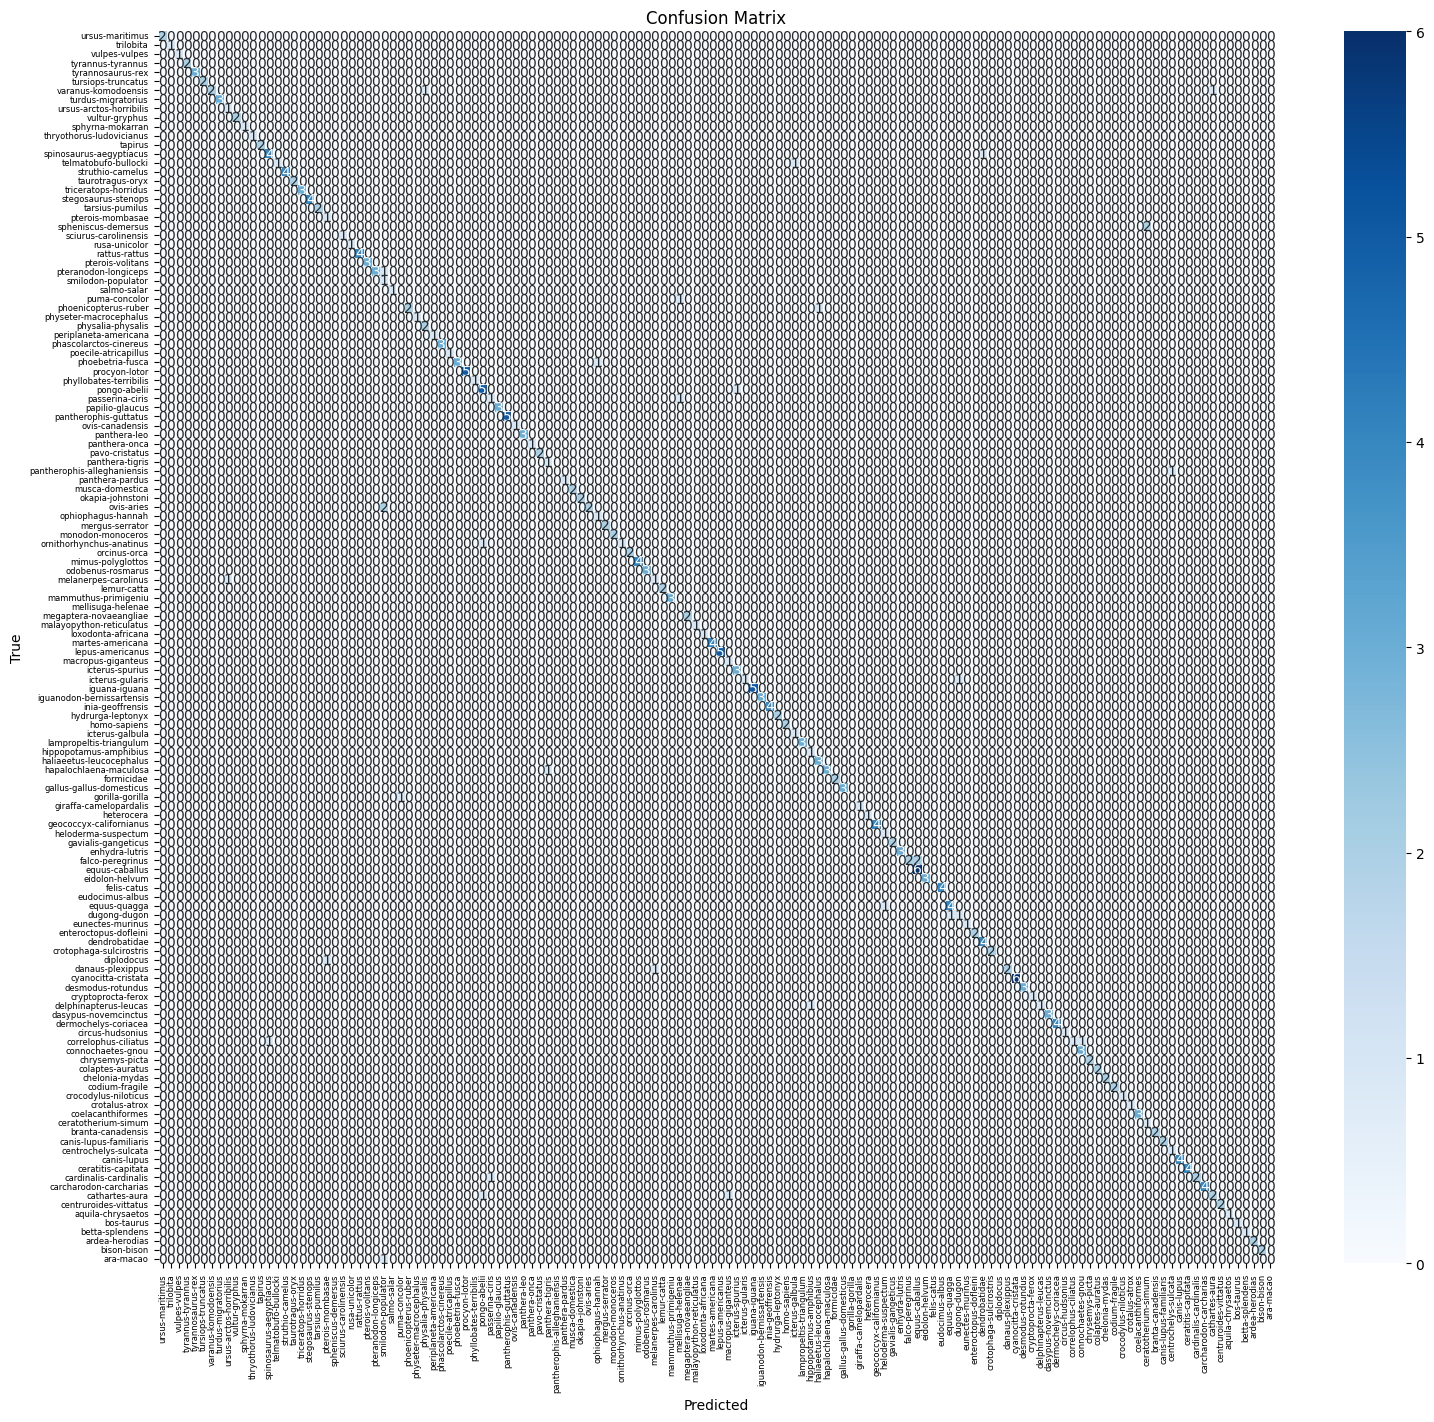

In [39]:
true_labels = []
pred_labels = []

for images, labels in test_dataset:
    true_labels.extend(labels.numpy())
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    pred_labels.extend(predicted_labels)

class_names = [
    'ursus-maritimus', 'trilobita', 'vulpes-vulpes', 'tyrannus-tyrannus', 'tyrannosaurus-rex', 'tursiops-truncatus',
    'varanus-komodoensis', 'turdus-migratorius', 'ursus-arctos-horribilis', 'vultur-gryphus', 'sphyrna-mokarran',
    'thryothorus-ludovicianus', 'tapirus', 'spinosaurus-aegyptiacus', 'telmatobufo-bullocki', 'struthio-camelus',
    'taurotragus-oryx', 'triceratops-horridus', 'stegosaurus-stenops', 'tarsius-pumilus', 'pterois-mombasae',
    'spheniscus-demersus', 'sciurus-carolinensis', 'rusa-unicolor', 'rattus-rattus', 'pterois-volitans',
    'pteranodon-longiceps', 'smilodon-populator', 'salmo-salar', 'puma-concolor', 'phoenicopterus-ruber',
    'physeter-macrocephalus', 'physalia-physalis', 'periplaneta-americana', 'phascolarctos-cinereus',
    'poecile-atricapillus', 'phoebetria-fusca', 'procyon-lotor', 'phyllobates-terribilis', 'pongo-abelii',
    'passerina-ciris', 'papilio-glaucus', 'pantherophis-guttatus', 'ovis-canadensis', 'panthera-leo', 'panthera-onca',
    'pavo-cristatus', 'panthera-tigris', 'pantherophis-alleghaniensis', 'panthera-pardus', 'musca-domestica',
    'okapia-johnstoni', 'ovis-aries', 'ophiophagus-hannah', 'mergus-serrator', 'monodon-monoceros',
    'ornithorhynchus-anatinus', 'orcinus-orca', 'mimus-polyglottos', 'odobenus-rosmarus', 'melanerpes-carolinus',
    'lemur-catta', 'mammuthus-primigeniu', 'mellisuga-helenae', 'megaptera-novaeangliae', 'malayopython-reticulatus',
    'loxodonta-africana', 'martes-americana', 'lepus-americanus', 'macropus-giganteus', 'icterus-spurius',
    'icterus-gularis', 'iguana-iguana', 'iguanodon-bernissartensis', 'inia-geoffrensis', 'hydrurga-leptonyx',
    'homo-sapiens', 'icterus-galbula', 'lampropeltis-triangulum', 'hippopotamus-amphibius', 'haliaeetus-leucocephalus',
    'hapalochlaena-maculosa', 'formicidae', 'gallus-gallus-domesticus', 'gorilla-gorilla', 'giraffa-camelopardalis',
    'heterocera', 'geococcyx-californianus', 'heloderma-suspectum', 'gavialis-gangeticus', 'enhydra-lutris',
    'falco-peregrinus', 'equus-caballus', 'eidolon-helvum', 'felis-catus', 'eudocimus-albus', 'equus-quagga',
    'dugong-dugon', 'eunectes-murinus', 'enteroctopus-dofleini', 'dendrobatidae', 'crotophaga-sulcirostris',
    'diplodocus', 'danaus-plexippus', 'cyanocitta-cristata', 'desmodus-rotundus', 'cryptoprocta-ferox',
    'delphinapterus-leucas', 'dasypus-novemcinctus', 'dermochelys-coriacea', 'circus-hudsonius', 'correlophus-ciliatus',
    'connochaetes-gnou', 'chrysemys-picta', 'colaptes-auratus', 'chelonia-mydas', 'codium-fragile', 'crocodylus-niloticus',
    'crotalus-atrox', 'coelacanthiformes', 'ceratotherium-simum', 'branta-canadensis', 'canis-lupus-familiaris',
    'centrochelys-sulcata', 'canis-lupus', 'ceratitis-capitata', 'cardinalis-cardinalis', 'carcharodon-carcharias',
    'cathartes-aura', 'centruroides-vittatus', 'aquila-chrysaetos', 'bos-taurus', 'betta-splendens', 'ardea-herodias',
    'bison-bison', 'ara-macao'
]

confusion_matrix_data = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(18, 16))
ax = sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 10})
plt.xlabel('Predicted')
plt.ylabel('True')

ax.set_xticklabels(ax.get_xticklabels(), size=6)
ax.set_yticklabels(ax.get_yticklabels(), size=6)

plt.title('Confusion Matrix')
plt.show()